In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Overview, main points covered

1. Cleaning data

    * check for missing data 
    -> "Customer ID"
    * duplicate values
    * negative values
    * doubtful entry -> cancellation without counterpart ['Quantity Cancelled']
    * TotalPrice = Price * (Quantity - Quantity Cancelled) 
    
    -> Removing TotalPrice < 0 (Cannot have more quantities cancelled than bought initially)
    * Removal of outliers (delete transaction with more than 10 times of standard deviation)
    
    

2. Feature engineering - Product tagging (for exploratory analysis for marketing)

    * cleaning the description using texthero -> hero.clean, 
    * hero.top_words 
    * product colour 


3. Feature engineering - Time features (for exploratory analysis .. )

    * Year
    * Month
    * MonthYear
    * Weekday
    * Day
    * Hour
    
4. RFM principle

    * Recency(R): Days since last purchase
    
    -> NOW = df.datetime(2011,12,10)
    
    -> Recency = NOW - rfmTable["Invoice Date"]
    
    -> min_recency (0-25th:1, 26-50th:2, 51-75th:3, 76-100th:4 percentile)
    
    -> The smaller the number, the more recent the last purchase is, the better
    * Frequency(F): Total number of purchases
    
    -> custom_aggregation["InvoiceDate"] = lambda x: len(x)
    -> 0-25th:4, 26-50th:3, 51-75th:2, 76-100th percentile:1 
    * Monetary value (M): Total money this customer spent    
       
    -> custom_aggregation["TotalPrice"] = "sum"
    -> 0-25th:4, 26-50th:3, 51-75th:2, 76-100th percentile:1 
    * Customer segmentation
    
    -> segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
    
5. Data visualization
    * Total Sales
    * Countries sold
    -> Customer distribution by country
    * Customers' segments
    * Most sold products
    * Best products monthly sale
    * Time features 
    
    -> Hourly sales
    
    -> Weekday sales
    
    -> Day of the month sales
    * Frequency distribution
    
    -> Recency
    -> Frequency
    -> Monetary
    * Box plot    
    
6. Clustering (The elbow method)

In [ ]:
!pip install texthero

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import texthero as hero
from scipy import stats
import plotly.express as px
import datetime as dt
import plotly.graph_objs as gog
import plotly.offline as pyoff
import plotly.graph_objects as go
import seaborn as sns

In [ ]:
df = pd.read_csv("../input/online-retail-ii-uci/online_retail_II.csv")
df.head(5)

In [ ]:
df.info()

# Getting to know the attributes

The dataframe contains 8 attributes:
* Invoice: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
* StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
* Price: Unit price. Numeric. Product price per unit in sterling (Â£).
* CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
* Country: Country name. Nominal. The name of the country where a customer resides.


# 1. Data Cleaning
## 1.1 Missing data
### 1.1.1 Checking for missing data
As you can see from the results, there are missing data present for the description and customerID

In [ ]:
df.isnull().sum()

In [ ]:
#Percentage of null with reference to entire dataset
for i in df:
    print("percentage of null values for " + str(i) + " is")
    value=(df[i].isnull().sum()/df.shape[0]) * 100
    print(round(value,4))
    print("\n")

Since the percentage of null values for Description is very low (0.4105%), i will drop these null values. As for CustomerID since the percentage of null values is quite high (22.7669%), before dropping these values, i will perform some exploratory analysis to look at the distribution of the null values for customerID. 

In [ ]:
df = df.drop(index=df[df['Description'].isnull()].index)

df.isnull().sum()

In [ ]:
df_customerid_null= df[df['Customer ID'].isnull()]


In [ ]:
df_customerid_null['InvoiceDate'] = pd.to_datetime(df_customerid_null['InvoiceDate'])

### 1.1.2 Exploratory analysis for missing data

Bar plots to compare the time distribution for df with null customerID values and df without null values.

List of time distributions undertaken:
1. Year
2. Month
3. Weekday
4. Hour

In [ ]:
#Time Features for data with null customerID values
df_customerid_null['Year'] = df_customerid_null["InvoiceDate"].apply(lambda x: x.year)
df_customerid_null['Month'] = df_customerid_null["InvoiceDate"].apply(lambda x: x.month)
df_customerid_null['Weekday'] = df_customerid_null["InvoiceDate"].apply(lambda x: x.weekday())
df_customerid_null['Hour'] = df_customerid_null["InvoiceDate"].apply(lambda x: x.hour)

In [ ]:
df_customerid_null['Num']=1
df_customerid_null.head(5)

In [ ]:
#Time features for original df with no null values
df_no_null = df.drop(index=df[df['Customer ID'].isnull()].index)

df_no_null.isnull().sum()

In [ ]:
df_no_null['Num']=1
df_no_null.head(5)

In [ ]:
df_no_null['InvoiceDate'] = pd.to_datetime(df_no_null['InvoiceDate'])

In [ ]:
#Time Features for data without null customerID values
df_no_null['Year'] = df_no_null["InvoiceDate"].apply(lambda x: x.year)
df_no_null['Month'] = df_no_null["InvoiceDate"].apply(lambda x: x.month)
df_no_null['Weekday'] = df_no_null["InvoiceDate"].apply(lambda x: x.weekday())
df_no_null['Hour'] = df_no_null["InvoiceDate"].apply(lambda x: x.hour)

In [ ]:
hourly_sales = df_customerid_null.groupby('Hour')['Num'].sum().sort_index(ascending=True)
x_hourly_sales = hourly_sales.index 
y_hourly_sales = hourly_sales.values
plt.bar(x_hourly_sales, y_hourly_sales, label = 'hourly sales_null')
plt.legend()

In [ ]:
hourly_sales_no_null = df_no_null.groupby('Hour')['Num'].sum().sort_index(ascending=True)
x_hourly_sales_no_null = hourly_sales_no_null.index 
y_hourly_sales_no_null = hourly_sales_no_null.values
plt.bar(x_hourly_sales_no_null, y_hourly_sales_no_null, label = 'hourly sales_no_null')
plt.legend()

As you can see from the two graphs, the hourly time distribution for the data with null customerID values is significantly different from the hourly time distribution for the data with no null values.

For example, for the 12th hour, the number of invoices is the highest in the second graph (data with no null values) whereas there is low numbers of invoices shown in the first graph.

The time distribution for the second graph is logical as the number of invoices is at its peak at around 12pm - 1pm which is understandable since most people will be awake and economic activity is the highest.

The time distribution for the first graph is alittle confusing as it peaks between 3pm-4pm which is the off-peak hour.

In [ ]:
weekday_sales = df_customerid_null.groupby('Weekday')['Num'].sum().sort_index(ascending=True)
x_weekday = weekday_sales.index 
y_weekday = weekday_sales.values
plt.bar(x_weekday, y_weekday, label = 'weekday sales')
plt.legend()

In [ ]:
weekday_sales_no_null = df_no_null.groupby('Weekday')['Num'].sum().sort_index(ascending=True)
x_weekday_sales_no_null = weekday_sales_no_null.index 
y_weekday_sales_no_null = weekday_sales_no_null.values
plt.bar(x_weekday_sales_no_null, y_weekday_sales_no_null, label = "weekday sales_no_null")
plt.legend()

I think there is some problems with the dataset regarding the distribution of weekday sales. There seems to be significantly less invoices on fridays compared to the other days.

The weekday distribution for the first graph is quite different from the second graph. For the first graph, the day with the highest and lowest(excluding friday) number of invoices are sunday and saturdays. For the second graph, the day with the highest and lowest(excluding friday) number of invoices are wednesday and thursday respectively.

In [ ]:
monthly_sales = df_customerid_null.groupby('Month')['Num'].sum().sort_index(ascending=True)
x_month = monthly_sales.index 
y_month = monthly_sales.values
plt.bar(x_month, y_month, label = 'monthly sales')
plt.legend()

In [ ]:
monthly_sales_no_null = df_no_null.groupby('Month')['Num'].sum().sort_index(ascending=True)
x_monthly_sales_no_null = monthly_sales_no_null.index 
y_monthly_sales_no_null = monthly_sales_no_null.values
plt.bar(x_monthly_sales_no_null, y_monthly_sales_no_null, label = "monthly sales_no_null")
plt.legend()

For the monthly sale, the distribution is relatively similar, where there are troughs in the early parts of the year and peaks in the late parts of the year.

In [ ]:
yearly_sales = df_customerid_null.groupby('Year')['Num'].sum().sort_index(ascending=True)
x_year = yearly_sales.index 
y_year = yearly_sales.values
plt.bar(x_year, y_year, label = 'yearly sales')
plt.legend()

In [ ]:
yearly_sales_no_null = df_no_null.groupby('Year')['Num'].sum().sort_index(ascending=True)
x_yearly_sales_no_null = yearly_sales_no_null.index 
y_yearly_sales_no_null = yearly_sales_no_null.values
plt.bar(x_yearly_sales_no_null, y_yearly_sales_no_null, label = "yearly sales_no_null")
plt.legend()

For the yearly sale, there is just three years and therefore it hard to make a good comparison. The overall distribution is quite similar where there are the least invoices for 2009 and relatively similar numbers for 2010 and 2011.

I will remove the null values for customerID for now.

In [ ]:
df = df.drop(index=df[df['Customer ID'].isnull()].index)

## 1.2 Duplicate values
I will be removing duplicate entries.

In [ ]:
# checking for duplicate transactions
print('Number of duplicate entries: {}'.format(df_no_null.duplicated().sum()))
df.drop_duplicates(inplace = True)

## 1.3 Negative values
### 1.3.1 Looking at the negative values

We will first look at the description of the dataset, especially the minimum and maximum values of the features.

In [ ]:
df.describe(include='all')

Surprisingly quanity has a negative number.

In [ ]:
negquantity = df[df['Quantity'] < 0]
negquantity.head(20)

It is noted that for negative quantity numbers, the invoice number contains the letter "C", which indicates a cancellation.

### 1.3.2 Cancelled orders

2.3% of the orders are cancelled.

In [ ]:
df['order_cancelled'] = df['Invoice'].apply(lambda x:int('C' in x))
# display(df[:5])

num_order_cancelled = df['order_cancelled'].sum()
total = df.shape[0]
print('Number of orders cancelled: {}/{} ({:.2f}%) '.format(num_order_cancelled, total, num_order_cancelled/total*100))

 

As you can see from the table above, for the first 9 rows, we can see cancellations made by the same person (Customer ID: 16321.0). I decide to see whether there are orders bought before with exactly the same attributes with exception of invoice number and invoiceDate. It is noted this is not present for the first 9 rows as the dataset starts at 2009-12-01 and hence the orders are likely to be bought previously on a date earlier and thus not present in the dataset.


In [ ]:
invoice = df[df['Customer ID'] == 16321.0]
invoice


To verify that this is true for all the invoices, I decide to locate the entries that indicate a negative quantity and check if there is an invoice with the exact same attributes except invoice number and invoiceDate.

Since we are aware that for invoices made on date 2009-12-01 is most likely not valid due to the fact that it is most likely bought before 2009-12-01 and hence not present in the dataset, we will just take a look at the 200th-240th wrong matching entries.

In [ ]:
df_check = df[df['Quantity'] < 0][['StockCode','Description','Quantity','InvoiceDate','Price','Customer ID']]
iterations=0
for index, col in  df_check.iterrows():
    if df[(df['Description'] == col[1]) & (df['Quantity'] == -col[2]) & (df['Customer ID'] == col[4])].shape[0] == 0:
        if(iterations<200):
            iterations+=1
        elif(iterations<240):
            print("----------Does not match----------")
            print(df_check.loc[index])
            iterations+=1
        else:
            break

#         break

The stock codes for the wrong matching is quite unexpected. Most of the StockCodes are expected(contains all numbers) but some of the stockCodes contains alphabets e.g. A, B, C, D, E, G, L, J, P, S, W which are located at the end of the StockCode. Upon closer inspection at the description, the alphabets are related to the product. For example, if you look at 233th-240th mismatch invoices, they all contain alphabets at the end of their stockCode and the alphabets in this case refers to the letters on the "BLING KEY RING". 

Upon closer inspection, I just want to check whether the particular customer ID == 14695 where the stockCode ends with the letter "L", as you can see the order is not matched.

In [ ]:
df.loc[(df["Customer ID"]==14695) & (df["StockCode"]=="90214L") ]

### 1.3.3 Discounted orders
Some of the negative quanity invoices are discounted too, as we can see in the description == "Discount".

In [ ]:
df_discount=df[df["Description"]=="Discount"]
df_discount

### 1.3.4 Data cleaning for cancellation

Since some of the cancellations are not matched, we are going to do datacleaning specifically to only those that matched. It is also important to note that for some of the orders that are not matched, it is most likely due to the fact that the order is placed before 2009-12-01 which is the date that the dataset starts.

** The below code takes 1 hour 20 mins to load **

In [ ]:
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtful_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['Customer ID'] == col['Customer ID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtful_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break     

In the above function, I checked the two cases:

1. a cancel order exists without counterpart
2. there's at least one counterpart with the exact same quantity

In [ ]:
total = df_cleaned.shape[0]
len_doubtful_entry=len(doubtful_entry)

print("entry_to_remove: {} ({:.2f}%)".format(len(entry_to_remove),(len(entry_to_remove)/total)*100))
print("doubtful_entry: {} ({:.2f}%)".format(len(doubtful_entry),(len(doubtful_entry)/total)*100))

We will be dropping the cancellation orders with counterpart as it is justified. Since the doubtful entries (cancellation without counterpart) covers a small percentage (0.24%), we will also drop those entries too.

Now we will check to see the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

In [ ]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtful_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("Number of entries not yet deleted: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

These are the cases where the number of cancellations are more than the purchase, which is wierd. 

** For now, we will not yet delete these. ** To be edited in the future

## 1.4 TotalPrice of each purchase

I created a new variable to indicate the total price of each purchase. We will be sorting the df according to customerID.

In [ ]:
df_cleaned['TotalPrice'] = df_cleaned['Price'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('Customer ID')[:5]

Each entry of the dataframe indicates prizes for a single kind of product. Hence, orders are split on several lines. I collect all the purchases made during a single order to recover the total order prize:

In [ ]:
temp = df_cleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

temp = df_cleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('Customer ID')[:6]

Below shows the distribution of the total price of individual purchases through the use of pie chart:

In [ ]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
     
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<x<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of individual purchases (x)", ha='center', fontsize = 18);

It can be seen that the vast majority of orders concern relatively large purchases given that 44% of purchases are between 200 and 500. Low cost purhcases (e.g. 0<x<50 and 50<x<100) form only a small component of individual purchases, 7 percent and 6 percent respectively.

## Can save the file here

In [ ]:
df_cleaned.to_csv('df_cleaned.csv')
# df_cleaned = pd.read_csv("../input/output/df_cleaned.csv")

## 1.5 Removal of outliers

We determine the cut-off for identifying outliers as more than 3 standard deviations from the mean.

In [ ]:
z = np.abs(stats.zscore(df_cleaned['TotalPrice']))
threshold = 3

df_cleaned_outliers = df_cleaned.copy(deep=True)
df_cleaned_outliers['Outliers'] = z

df_cleaned_outliers[df_cleaned_outliers['Outliers']>threshold]

In [ ]:
len_outlier=df_cleaned_outliers[df_cleaned_outliers['Outliers']>threshold]

In [ ]:
len_outlier=df_cleaned_outliers[df_cleaned_outliers['Outliers']>threshold].shape[0]
total = df_cleaned.shape[0]

print("entry_to_remove: {} ({:.2f}%)".format(len_outlier,(len_outlier/total)*100))

In [ ]:
df_cleaned.drop(df_cleaned_outliers[df_cleaned_outliers['Outliers']>threshold].index, axis = 0, inplace = True)

# 2. Feature engineering - Product tagging (for exploratory analysis for marketing)


In the dataframe, products are uniquely identified through the StockCode variable. A shrort description of the products is given in the Description variable. In this section, I intend to use the content of this latter variable in order to group the products into different categories.

## 2.1 Cleaning the description

In [ ]:
# product_df = df_cleaned.drop(columns=['StockCode', 'Invoice', 'Customer ID', 'Price', 'Quantity', 'InvoiceDate', 'Country'])
df_cleaned['Description_clean'] = df_cleaned['Description'].pipe(hero.clean)

In [ ]:
tw = hero.visualization.top_words(df_cleaned['Description_clean']).head(40)

fig = px.bar(tw)
fig.show()

We are able to see that "set", "red", "bag", "heart" and "pink" are the most common words that appear in the description. However, a better approach will be to look at the top words that appear for respective months since some months have special holidays that may alter the consumer's spending patterns. Below show the top words that appear in the description for each month.

# 3 Feature engineering - Time features (for exploratory analysis .. )

Previously we have done some feature engineering regarding the description, time, price etc. Here we will be doing feature engineering specifically for the time features, which we will be using in the later sections. It is noted that this process has been done previously to compare the time distribution between the invoices with null values and the invoices without null values. The difference this time is that it will be done on a cleaned dataset.

The time features are:
* Year
* Month
* MonthYear
* Weekday
* Day
* Hour

In [ ]:
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
df_cleaned['Year'] = df_cleaned["InvoiceDate"].apply(lambda x: x.year)
df_cleaned['Month'] = df_cleaned["InvoiceDate"].apply(lambda x: x.month)
# df_cleaned['MonthYear'] = df_cleaned["InvoiceDate"].apply(lambda x: x.strftime("%B %Y"))
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].apply(lambda x: x.weekday())
# df_cleaned['Day'] = df_cleaned["InvoiceDate"].apply(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].apply(lambda x: x.hour)

In [ ]:
df_cleaned_1=df_cleaned[df_cleaned["Month"]== 1]
df_cleaned_2=df_cleaned[df_cleaned["Month"]== 2]
df_cleaned_3=df_cleaned[df_cleaned["Month"]== 3]
df_cleaned_4=df_cleaned[df_cleaned["Month"]== 4]
df_cleaned_5=df_cleaned[df_cleaned["Month"]== 5]
df_cleaned_6=df_cleaned[df_cleaned["Month"]== 6]
df_cleaned_7=df_cleaned[df_cleaned["Month"]== 7]
df_cleaned_8=df_cleaned[df_cleaned["Month"]== 8]
df_cleaned_9=df_cleaned[df_cleaned["Month"]== 9]
df_cleaned_10=df_cleaned[df_cleaned["Month"]== 10]
df_cleaned_11=df_cleaned[df_cleaned["Month"]== 11]
df_cleaned_12=df_cleaned[df_cleaned["Month"]== 12]

In [ ]:


tw_1 = hero.visualization.top_words(df_cleaned_1['Description_clean']).head(20)
tw_2 = hero.visualization.top_words(df_cleaned_2['Description_clean']).head(20)
tw_3 = hero.visualization.top_words(df_cleaned_3['Description_clean']).head(20)

tw_4 = hero.visualization.top_words(df_cleaned_4['Description_clean']).head(20)
tw_5 = hero.visualization.top_words(df_cleaned_5['Description_clean']).head(20)
tw_6 = hero.visualization.top_words(df_cleaned_6['Description_clean']).head(20)

tw_7 = hero.visualization.top_words(df_cleaned_7['Description_clean']).head(20)
tw_8 = hero.visualization.top_words(df_cleaned_8['Description_clean']).head(20)
tw_9 = hero.visualization.top_words(df_cleaned_9['Description_clean']).head(20)

tw_10 = hero.visualization.top_words(df_cleaned_10['Description_clean']).head(20)
tw_11 = hero.visualization.top_words(df_cleaned_11['Description_clean']).head(20)
tw_12 = hero.visualization.top_words(df_cleaned_12['Description_clean']).head(20)

fig, axes = plt.subplots(4, 3, figsize=(18, 36))
# plt.xticks(rotation=90)
# fig.suptitle('Initial Pokemon - 1st Generation')

sns.barplot(ax=axes[0,0], x=tw_1.index, y=tw_1.values)
axes[0,0].set_title("January")
axes[0,0].tick_params(labelrotation=90)

sns.barplot(ax=axes[0,1], x=tw_2.index, y=tw_2.values)
axes[0,1].set_title("February")
axes[0,1].tick_params(labelrotation=90)

sns.barplot(ax=axes[0,2], x=tw_3.index, y=tw_3.values)
axes[0,2].set_title("March")
axes[0,2].tick_params(labelrotation=90)

sns.barplot(ax=axes[1,0], x=tw_4.index, y=tw_4.values)
axes[1,0].set_title("April")
axes[1,0].tick_params(labelrotation=90)

sns.barplot(ax=axes[1,1], x=tw_5.index, y=tw_5.values)
axes[1,1].set_title("May")
axes[1,1].tick_params(labelrotation=90)

sns.barplot(ax=axes[1,2], x=tw_6.index, y=tw_6.values)
axes[1,2].set_title("June")
axes[1,2].tick_params(labelrotation=90)

sns.barplot(ax=axes[2,0], x=tw_7.index, y=tw_7.values)
axes[2,0].set_title("July")
axes[2,0].tick_params(labelrotation=90)

sns.barplot(ax=axes[2,1], x=tw_8.index, y=tw_8.values)
axes[2,1].set_title("August")
axes[2,1].tick_params(labelrotation=90)

sns.barplot(ax=axes[2,2], x=tw_9.index, y=tw_9.values)
axes[2,2].set_title("September")
axes[2,2].tick_params(labelrotation=90)

sns.barplot(ax=axes[3,0], x=tw_10.index, y=tw_10.values)
axes[3,0].set_title("October")
axes[3,0].tick_params(labelrotation=90)

sns.barplot(ax=axes[3,1], x=tw_11.index, y=tw_11.values)
axes[3,1].set_title("November")
axes[3,1].tick_params(labelrotation=90)

sns.barplot(ax=axes[3,2], x=tw_12.index, y=tw_12.values)
axes[3,2].set_title("December")
axes[3,2].tick_params(labelrotation=90)

# 4 RFM principle

RFM stands for Recency, Frequency and Monetary value respectively.

* Recency(R): Days since last purchase
* Frequency(F): Total number of purchases
* Monetary value (M): Total money this customer spent

RFM is a model based on customer segmentation and it helps to divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

## 4.1 Recency - feature engineering

In [ ]:
df_cleaned['InvoiceDate'].max()

Based on the dataset the maximum invoice date is '2011-12-09 12:50:00'. Therefore, we set the compared_date used to calculate the recency of the invoice as 2011-12-10 which is a day after the maximum date.

In [ ]:
compared_date=dt.datetime(2011,12,10)

Create another table for better backup incase code is wrong.

In [ ]:
df_rfm=df_cleaned.copy()

Since date is not really very important we are just going to take the first date of the single purchase

In [ ]:
custom_aggregation={}
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["Customer ID"] = lambda x:x.iloc[0]
custom_aggregation["TotalPrice"] = "sum"
df_rfm_final = df_rfm.groupby("Invoice").agg(custom_aggregation)

In [ ]:
df_rfm_final["Recency"] = compared_date - df_rfm_final["InvoiceDate"]
df_rfm_final["Recency"] = pd.to_timedelta(df_rfm_final["Recency"]).astype("timedelta64[D]")
df_rfm_final.head(5)


Below shows the distribution of recency. The distribution looks alittle bit wierd as for days 340-349, the number of invoices with the particular range of recency is 0. The distribution of recency follows a periodic trend where there is a periodic period of peaks and troughs. A possible explanation could be due to the holiday season. If you refer to the month distribution bar graph in 1.1.2, you can see that the amount of invoices made (which is correlated to sales) peaks in the later part of the year and slumps at the start of the year, therefore it is able to justify the periodic trend of the bar plot for recency.

In [ ]:
#plot a recency histogram

plot_data = [
    go.Histogram(
        x=df_rfm_final['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## 4.2 Frequency & Monetary Value - feature engineering

In [ ]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min"]
custom_aggregation["InvoiceDate"] = lambda x: len(x)
custom_aggregation["TotalPrice"] = "sum"
df_rfm_final_final = df_rfm_final.groupby("Customer ID").agg(custom_aggregation)

In [ ]:
df_rfm_final_final.head(5)

renaming the columns

In [ ]:
df_rfm_final_final.columns = ["min_recency", "frequency", "monetary_value"]

In [ ]:
df_rfm_final_final.head(5)

In [ ]:
#plot a recency histogram FOR CUSTOMERS

plot_data = [
    go.Histogram(
        x=df_rfm_final_final['min_recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

As we can see as the dates increase, the number of customers decrease, This shows that there is actually a high number of returning customers/frequent customers, which is a good sign or it could also mean that alot of the customers are new customers (this is most likely the case when you look at the frequency graph below)

In [ ]:
#plot a frequency histogram

plot_data = [
    go.Histogram(
        x=df_rfm_final_final['frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

The frequency graph shows that alot of customers only went to the store a few times and there are very little loyal cusstomers (people who frequent the shop)

In [ ]:
plot_data = [
    go.Histogram(
        x=df_rfm_final_final['monetary_value']
    )
]

plot_layout = go.Layout(
        title='monetary_value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

The graph is expected where most customers' monetary value belongs in the 0-1000 dollar range and the number of customers belonging to the higher monetary value brackets sharply decrease.

## 4.3 Customer segregation

Here we will start segregating based on the percentile of the attribute. The attibutes are min_recency, frequency and monetary_value for 1. Recency, 2. Frequency and 3. Monetary value respectively. Based on the respective percentile, we will be allocating a score from 1 to 4. 1 would be the best score and 4 would be the worst.

* For 1. Recency, the smaller the min_recency, the more recent the last purchase is, and hence it is better. 

        -> min_recency (0-25th:1, 26-50th:2, 51-75th:3, 76-100th:4 percentile)

* For 2. Frequency and 3. Monetary value, the larger their respective attributes the better.

        -> 0-25th:4, 26-50th:3, 51-75th:2, 76-100th percentile:1 

In [ ]:
df_rfm_final_copy=df_rfm_final_final.copy()

In [ ]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [ ]:
df_rfm_final_copy.head(5)

In [ ]:
quantiles = df_rfm_final_copy.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [ ]:
df_rfm_final_copy['r_quartile'] = df_rfm_final_copy['min_recency'].apply(RScore, args=('min_recency',quantiles,))
df_rfm_final_copy['f_quartile'] = df_rfm_final_copy['frequency'].apply(FMScore, args=('frequency',quantiles,))
df_rfm_final_copy['m_quartile'] = df_rfm_final_copy['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
df_rfm_final_copy.head()

We will be combining the individual quartile numbers for recency, frequency and monetary value together.

In [ ]:
df_rfm_final_copy['RFMScore'] = df_rfm_final_copy.r_quartile.map(str) + df_rfm_final_copy.f_quartile.map(str) + df_rfm_final_copy.m_quartile.map(str)
df_rfm_final_copy['RFMScore'] = df_rfm_final_copy['RFMScore'].astype(int)
df_rfm_final_copy.head()

Overall Score: average out the quartile numbers

In [ ]:
df_rfm_final_copy['OverallScore'] = (df_rfm_final_copy['r_quartile'] + df_rfm_final_copy['f_quartile'] + df_rfm_final_copy['m_quartile'])/3

#not sure of the line below
# df_rfm_final_copy.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

This is what the dataframe looks like now after I have add the attributes "r_quartile","f_quartile","m_quartile","RFMScore" and "OverallScore".

In [ ]:
df_rfm_final_copy.head(5)

I also created a new attribute called "Segment" which segments the customers according to their OverallScore value respectively

In [ ]:
#not sure on the segment distribution
df_rfm_final_copy['Segment'] = 'High-Value'
df_rfm_final_copy.loc[df_rfm_final_copy['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_rfm_final_copy.loc[df_rfm_final_copy['OverallScore']>3,'Segment'] = 'Low-Value' 

In [ ]:
total_count=df_rfm_final_copy['min_recency'].count()
high_value_count=df_rfm_final_copy[df_rfm_final_copy['Segment'] == 'High-Value']['min_recency'].count()
mid_value_count=df_rfm_final_copy[df_rfm_final_copy['Segment'] == 'Mid-Value']['min_recency'].count()
low_value_count=df_rfm_final_copy[df_rfm_final_copy['Segment'] == 'Low-Value']['min_recency'].count()

print("high_value_count: {} ({:.2f}%)".format(high_value_count,(high_value_count/total_count)*100))
print("mid_value_count: {} ({:.2f}%)".format(mid_value_count,(mid_value_count/total_count)*100))
print("low_value_count: {} ({:.2f}%)".format(low_value_count,(low_value_count/total_count)*100))

In [ ]:
df_rfm_final_copy['monetary_value'].describe()

In [ ]:
df_rfm_final_copy['frequency'].describe()

In [ ]:
#Revenue vs Frequency
tx_graph = df_rfm_final_copy.copy()

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['monetary_value'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['monetary_value'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['monetary_value'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Low-value customers spend too little (cannot even see on the map. Range is from 0 to 2200 in Revenue. The greater the frequency, the lower the revenue. 

Mid-value customers spend more than low-value customers, range around 0 to 30000 in Revenue. The same trend is also present where the greater the frequency, the lower the revenue.

High-value customers spend alot more than mid-value customers , range around 0 to 500000 in Revenue. The trend is different for this case as the amount of revenue increases when frequency increases, which makes sense.

In [ ]:
#Revenue Recency

tx_graph = df_rfm_final_copy.copy()

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['min_recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['monetary_value'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['min_recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['monetary_value'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['min_recency'],
        y=tx_graph.query("Segment == 'High-Value'")['monetary_value'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)



In [ ]:
# Revenue vs Frequency
tx_graph = df_rfm_final_copy.copy()

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['min_recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['min_recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['min_recency'],
        y=tx_graph.query("Segment == 'High-Value'")['frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Since we have already obtained the RFMScore, we will drop the attributes, "r_quartile","f_quartile" and "m_quartile".

In [ ]:
df_rfm_final_final_copy= df_rfm_final_copy.drop(['r_quartile','f_quartile','m_quartile'], 1)

Sort according to the RFM scores from the best customers (score 111):
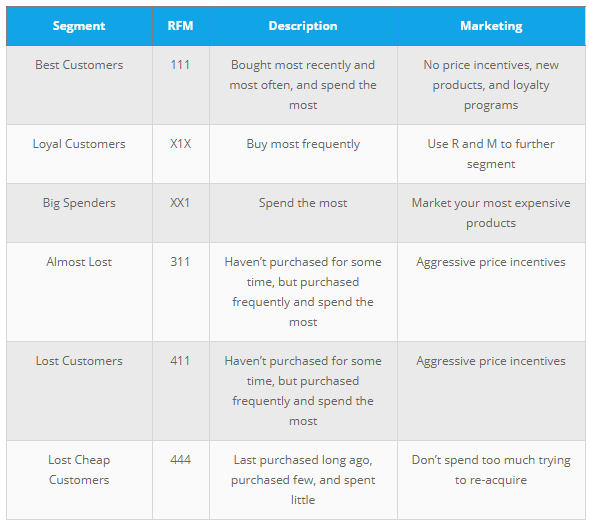
Source: Blast Analytics Marketing

In [ ]:
df_rfm_final_final_copy['Customer_type']=0

df_rfm_final_final_copy.loc[(df_rfm_final_final_copy.Segment == "High-Value"), 'Customer_type'] = 'Good Customers'

df_rfm_final_final_copy.loc[(df_rfm_final_final_copy.Segment == "Mid-Value"), 'Customer_type'] = 'Average Customers'

df_rfm_final_final_copy.loc[(df_rfm_final_final_copy.Segment == "Low-Value"), 'Customer_type'] = 'Bad Customers'

df_rfm_final_final_copy.loc[(df_rfm_final_final_copy.RFMScore == 111), 'Customer_type'] = 'Best Customers'

for num in [112, 113, 114, 212, 213, 214, 312, 313, 314, 412, 413, 414] : 
    df_rfm_final_final_copy.loc[(df_rfm_final_final_copy.RFMScore == num), 'Customer_type'] = 'Loyal Customers'
    
for num in [121, 131, 141, 221, 231, 241, 321, 331, 341, 421, 431, 441] : 
    df_rfm_final_final_copy.loc[(df_rfm_final_final_copy.RFMScore == num), 'Customer_type'] = 'Big Spenders'
    
df_rfm_final_final_copy.loc[(df_rfm_final_final_copy.RFMScore == 311), 'Customer_type'] = 'Almost Lost'

df_rfm_final_final_copy.loc[(df_rfm_final_final_copy.RFMScore == 411), 'Customer_type'] = 'Lost Customers'

df_rfm_final_final_copy.loc[(df_rfm_final_final_copy.RFMScore == 444), 'Customer_type'] = 'Lost Cheap Customers'

In [ ]:
df_rfm_final_final_copy

# 5. Data visualization

Based on the customer segmentation we have done previously, we will now take a closer look at the individual customer type.

I think need to merge both datasets

In [ ]:
df_combine=df_cleaned.copy()

In [ ]:
df_combine.head(5)

In [ ]:
df_good_customers=df_rfm_final_final_copy[df_rfm_final_final_copy['Customer_type']=='Good Customers']
df_good_customers_merge=pd.merge(df_good_customers, df_combine, left_index=True, right_index=True)

In [ ]:
good_customers_list=df_good_customers.index.values
mask = df_combine['Customer ID'].isin(good_customers_list)
df_good_customers_merge=df_combine.loc[mask]
df_good_customers_dataset=df_good_customers_merge.groupby(['Year','Month']).sum()
df_good_customers_dataset.index = [df_good_customers_dataset.index.get_level_values(0), df_good_customers_dataset.index.map('{0[1]}/{0[0]}'.format)]
df_good_customer_testing=df_good_customers_dataset.droplevel(level=0)

In [ ]:
df_good_customers = df_good_customer_testing['TotalPrice']
x_df_good_customers = df_good_customers.index 
y_df_good_customers = df_good_customers.values
plt.bar(x_df_good_customers, y_df_good_customers, label = "monthly sales_good_customer",color="springgreen")
plt.xticks(rotation=90)
plt.legend()

It seems like the sales made by good customers is increasing from 2010 to 2011 comparatively across all months, which is a good sign. The most noticable would be the increase in sales would be 9/2011, 10/2011 and 11/2011 compared to 9/2010, 10/2010 and 11/2010. This trend is not present for all the other customer segments. Working with the marketing team would be useful in determining the reason for this improvement in sales and this info could be use to further increase sales made by good customers for the following years.

In [ ]:
df_average_customers=df_rfm_final_final_copy[df_rfm_final_final_copy['Customer_type']=='Average Customers']
df_average_customers_merge=pd.merge(df_average_customers, df_combine, left_index=True, right_index=True)

average_customers_list=df_average_customers.index.values
mask = df_combine['Customer ID'].isin(average_customers_list)
df_average_customers_merge=df_combine.loc[mask]
df_average_customers_dataset=df_average_customers_merge.groupby(['Year','Month']).sum()
df_average_customers_dataset.index = [df_average_customers_dataset.index.get_level_values(0), df_average_customers_dataset.index.map('{0[1]}/{0[0]}'.format)]
df_average_customer_testing=df_average_customers_dataset.droplevel(level=0)

df_average_customers = df_average_customer_testing['TotalPrice']
x_df_average_customers = df_average_customers.index 
y_df_average_customers = df_average_customers.values
plt.bar(x_df_average_customers, y_df_average_customers, label = "monthly sales_average_customer",color="yellow")
plt.xticks(rotation=90)
plt.legend()

There seems to be a drop in average customer monthly sales from 2010 to 2011, especially in the decrease in sales for 10/2011 and 11/2011 when compared to 10/2010 and 11/2010.

In [ ]:
df_bad_customers=df_rfm_final_final_copy[df_rfm_final_final_copy['Customer_type']=='Bad Customers']
df_bad_customers_merge=pd.merge(df_bad_customers, df_combine, left_index=True, right_index=True)

bad_customers_list=df_bad_customers.index.values
mask = df_combine['Customer ID'].isin(bad_customers_list)
df_bad_customers_merge=df_combine.loc[mask]
df_bad_customers_dataset=df_bad_customers_merge.groupby(['Year','Month']).sum()
df_bad_customers_dataset.index = [df_bad_customers_dataset.index.get_level_values(0), df_bad_customers_dataset.index.map('{0[1]}/{0[0]}'.format)]
df_bad_customer_testing=df_bad_customers_dataset.droplevel(level=0)

df_bad_customers = df_bad_customer_testing['TotalPrice']
x_df_bad_customers = df_bad_customers.index 
y_df_bad_customers = df_bad_customers.values
plt.bar(x_df_bad_customers, y_df_bad_customers, label = "monthly sales_bad_customer",color="firebrick")
plt.xticks(rotation=90)
plt.legend()

The bad customer monthly sale dropped drastically at 12/2010. Since these are bad customers who are of low value, it may be a waste of resources for the marketing team to target the segment to increase in sales and it would be more efficient to target higher value customers.

In [ ]:
df_best_customers=df_rfm_final_final_copy[df_rfm_final_final_copy['Customer_type']=='Best Customers']
df_best_customers_merge=pd.merge(df_best_customers, df_combine, left_index=True, right_index=True)

best_customers_list=df_best_customers.index.values
mask = df_combine['Customer ID'].isin(best_customers_list)
df_best_customers_merge=df_combine.loc[mask]
df_best_customers_dataset=df_best_customers_merge.groupby(['Year','Month']).sum()
df_best_customers_dataset.index = [df_best_customers_dataset.index.get_level_values(0), df_best_customers_dataset.index.map('{0[1]}/{0[0]}'.format)]
df_best_customer_testing=df_best_customers_dataset.droplevel(level=0)

df_best_customers = df_best_customer_testing['TotalPrice']
x_df_best_customers = df_best_customers.index 
y_df_best_customers = df_best_customers.values
plt.bar(x_df_best_customers, y_df_best_customers, label = "monthly sales_best_customer",color="lawngreen")
plt.xticks(rotation=90)
plt.legend()

It seems like the sales made by best customers is increasing from 2010 to 2011 comparatively across all months, which is a good sign. The most noticable would be the increase in sales would be 9/2011, 10/2011 and 11/2011 compared to 9/2010, 10/2010 and 11/2010. This trend is not present for all the other customer segments. Working with the marketing team would be useful in determining the reason for this improvement in sales and this info could be use to further increase sales made by best customers for the following years. This is very important as these customers are of the highest value.

In [ ]:
df_loyal_customers=df_rfm_final_final_copy[df_rfm_final_final_copy['Customer_type']=='Loyal Customers']
df_loyal_customers_merge=pd.merge(df_loyal_customers, df_combine, left_index=True, right_index=True)

loyal_customers_list=df_loyal_customers.index.values
mask = df_combine['Customer ID'].isin(loyal_customers_list)
df_loyal_customers_merge=df_combine.loc[mask]
df_loyal_customers_dataset=df_loyal_customers_merge.groupby(['Year','Month']).sum()
df_loyal_customers_dataset.index = [df_loyal_customers_dataset.index.get_level_values(0), df_loyal_customers_dataset.index.map('{0[1]}/{0[0]}'.format)]
df_loyal_customer_testing=df_loyal_customers_dataset.droplevel(level=0)

df_loyal_customers = df_loyal_customer_testing['TotalPrice']
x_df_loyal_customers = df_loyal_customers.index 
y_df_loyal_customers = df_loyal_customers.values
plt.bar(x_df_loyal_customers, y_df_loyal_customers, label = "monthly sales_loyal_customer",color="pink")
plt.xticks(rotation=90)
plt.legend()


The loyal customer monthly sale dropped alittle from 2010 to 2011. It is most likely due to the poor marketing campaign targetted at the customer segment.

In [ ]:
df_big_spenders_customers=df_rfm_final_final_copy[df_rfm_final_final_copy['Customer_type']=='Big Spenders']
df_big_spenders_customers_merge=pd.merge(df_big_spenders_customers, df_combine, left_index=True, right_index=True)

big_spenders_customers_list=df_big_spenders_customers.index.values
mask = df_combine['Customer ID'].isin(big_spenders_customers_list)
df_big_spenders_customers_merge=df_combine.loc[mask]
df_big_spenders_customers_dataset=df_big_spenders_customers_merge.groupby(['Year','Month']).sum()
df_big_spenders_customers_dataset.index = [df_big_spenders_customers_dataset.index.get_level_values(0), df_big_spenders_customers_dataset.index.map('{0[1]}/{0[0]}'.format)]
df_big_spenders_customer_testing=df_big_spenders_customers_dataset.droplevel(level=0)

df_big_spenders_customers = df_big_spenders_customer_testing['TotalPrice']
x_df_big_spenders_customers = df_big_spenders_customers.index 
y_df_big_spenders_customers = df_big_spenders_customers.values
plt.bar(x_df_big_spenders_customers, y_df_big_spenders_customers, label = "monthly sales_big_spenders_customer",color="aqua")
plt.xticks(rotation=90)
plt.legend()

It seems like the sales made by big spenders customers is increasing from 2010 to 2011 comparatively across all months, which is a good sign. The most noticable would be the increase in sales would be 9/2011, 10/2011 and 11/2011 compared to 9/2010, 10/2010 and 11/2010. This trend is not present for all the other customer segments. Working with the marketing team would be useful in determining the reason for this improvement in sales and this info could be use to further increase sales made by big spenders customers for the following years. 

In [ ]:
df_almost_lost_customers=df_rfm_final_final_copy[df_rfm_final_final_copy['Customer_type']=='Almost Lost']
df_almost_lost_customers_merge=pd.merge(df_almost_lost_customers, df_combine, left_index=True, right_index=True)

almost_lost_customers_list=df_almost_lost_customers.index.values
mask = df_combine['Customer ID'].isin(almost_lost_customers_list)
df_almost_lost_customers_merge=df_combine.loc[mask]
df_almost_lost_customers_dataset=df_almost_lost_customers_merge.groupby(['Year','Month']).sum()
df_almost_lost_customers_dataset.index = [df_almost_lost_customers_dataset.index.get_level_values(0), df_almost_lost_customers_dataset.index.map('{0[1]}/{0[0]}'.format)]
df_almost_lost_customer_testing=df_almost_lost_customers_dataset.droplevel(level=0)

df_almost_lost_customers = df_almost_lost_customer_testing['TotalPrice']
x_df_almost_lost_customers = df_almost_lost_customers.index 
y_df_almost_lost_customers = df_almost_lost_customers.values
plt.bar(x_df_almost_lost_customers, y_df_almost_lost_customers, label = "monthly sales_almost_lost_customer",color="darkviolet")
plt.xticks(rotation=90)
plt.legend()

In [ ]:
df_lost_customers=df_rfm_final_final_copy[df_rfm_final_final_copy['Customer_type']=='Lost Customers']
df_lost_customers_merge=pd.merge(df_lost_customers, df_combine, left_index=True, right_index=True)

lost_customers_list=df_lost_customers.index.values
mask = df_combine['Customer ID'].isin(lost_customers_list)
df_lost_customers_merge=df_combine.loc[mask]
df_lost_customers_dataset=df_lost_customers_merge.groupby(['Year','Month']).sum()
df_lost_customers_dataset.index = [df_lost_customers_dataset.index.get_level_values(0), df_lost_customers_dataset.index.map('{0[1]}/{0[0]}'.format)]
df_lost_customer_testing=df_lost_customers_dataset.droplevel(level=0)

df_lost_customers = df_lost_customer_testing['TotalPrice']
x_df_lost_customers = df_lost_customers.index 
y_df_lost_customers = df_lost_customers.values
plt.bar(x_df_lost_customers, y_df_lost_customers, label = "monthly sales_lost_customer",color="blue")
plt.xticks(rotation=90)
plt.legend()

In [ ]:
df_rfm_final_final_copy[df_rfm_final_final_copy['Customer_type']=='Lost Cheap Customers']

In [ ]:
df_lost_cheap_customers=df_rfm_final_final_copy[df_rfm_final_final_copy['Customer_type']=='Lost Cheap Customers']
df_lost_cheap_customers_merge=pd.merge(df_lost_cheap_customers, df_combine, left_index=True, right_index=True)

lost_cheap_customers_list=df_lost_cheap_customers.index.values
mask = df_combine['Customer ID'].isin(lost_cheap_customers_list)
df_lost_cheap_customers_merge=df_combine.loc[mask]
df_lost_cheap_customers_dataset=df_lost_cheap_customers_merge.groupby(['Year','Month']).sum()
df_lost_cheap_customers_dataset.index = [df_lost_cheap_customers_dataset.index.get_level_values(0), df_lost_cheap_customers_dataset.index.map('{0[1]}/{0[0]}'.format)]
df_lost_cheap_customer_testing=df_lost_cheap_customers_dataset.droplevel(level=0)

df_lost_cheap_customers = df_lost_cheap_customer_testing['TotalPrice']
x_df_lost_cheap_customers = df_lost_cheap_customers.index 
y_df_lost_cheap_customers = df_lost_cheap_customers.values
plt.bar(x_df_lost_cheap_customers, y_df_lost_cheap_customers, label = "monthly sales_lost_cheap_customer",color="black")
plt.xticks(rotation=90)
plt.legend()

https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444

We can also create an overall score using kmeans-clustering